In [1]:
# 讽刺文本: 通过一种夸张, 反讽对比的手段进行表达

In [11]:
# 下周数据
import requests
import zipfile
import io

from numpy.ma.extras import hstack
from yt_dlp.aes import rotate

url = 'http://labfile.oss.aliyuncs.com/courses/1283/train-balanced-sarcasm.csv.zip'

# 下载文件
response = requests.get(url, stream=True)
if response.status_code == 200:
    # 将下载的文件保存到内存中
    zip_file = zipfile.ZipFile(io.BytesIO(response.content))
    # 解压文件到当前目录
    zip_file.extractall()
    print('文件已下载成功并解压')
else:
    print('文件下载失败', response)

文件已下载成功并解压


In [12]:
# 导入库
#导入库
import os
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [14]:
# 读取数据
train_df = pd.read_csv('train-balanced-sarcasm.csv')
train_df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [16]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010826 entries, 0 to 1010825
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   label           1010826 non-null  int64 
 1   comment         1010771 non-null  object
 2   author          1010826 non-null  object
 3   subreddit       1010826 non-null  object
 4   score           1010826 non-null  int64 
 5   ups             1010826 non-null  int64 
 6   downs           1010826 non-null  int64 
 7   date            1010826 non-null  object
 8   created_utc     1010826 non-null  object
 9   parent_comment  1010826 non-null  object
dtypes: int64(4), object(6)
memory usage: 77.1+ MB


In [20]:
# 从以上结果可以看出, comment的数据是小于其他的特征数据, 说明存在缺失值, 将缺失删除
train_df.dropna(subset= 'comment', inplace = True)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1010771 entries, 0 to 1010825
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   label           1010771 non-null  int64 
 1   comment         1010771 non-null  object
 2   author          1010771 non-null  object
 3   subreddit       1010771 non-null  object
 4   score           1010771 non-null  int64 
 5   ups             1010771 non-null  int64 
 6   downs           1010771 non-null  int64 
 7   date            1010771 non-null  object
 8   created_utc     1010771 non-null  object
 9   parent_comment  1010771 non-null  object
dtypes: int64(4), object(6)
memory usage: 84.8+ MB


In [22]:
# 查看数据标签的类别是否平衡
train_df['label'].value_counts()

label
0    505403
1    505368
Name: count, dtype: int64

In [24]:
# 将数据集进行切分, 切分成训练集和测试集
train_texts, valid_texts, y_train, y_valid = train_test_split(train_df['comment'], train_df['label'],
                                                              random_state=17
                                                            )

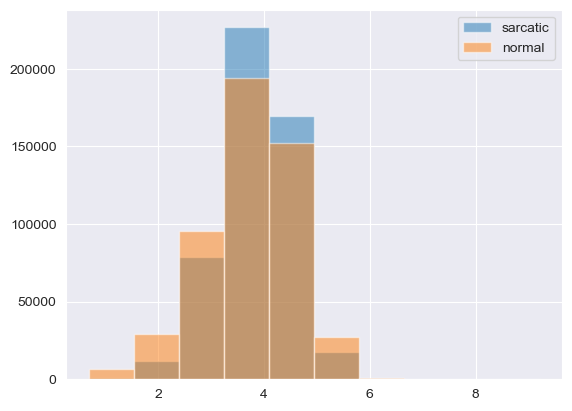

In [26]:
# 数据可视化探索
# 利用条形图可视化讽刺文本, 再利用np.log1p对数, 进行平滑处理, 压缩到一定范围内
train_df.loc[train_df['label'] == 1, 'comment'].str.len().apply(np.log1p).hist(label = 'sarcatic', alpha = 0.5)
train_df.loc[train_df['label'] == 0, 'comment'].str.len().apply(np.log1p).hist(label = 'normal', alpha = 0.5)
plt.legend()
plt.show()

In [27]:
# 从图中可以看出二者在不同长度区间范围内的技术分布均匀

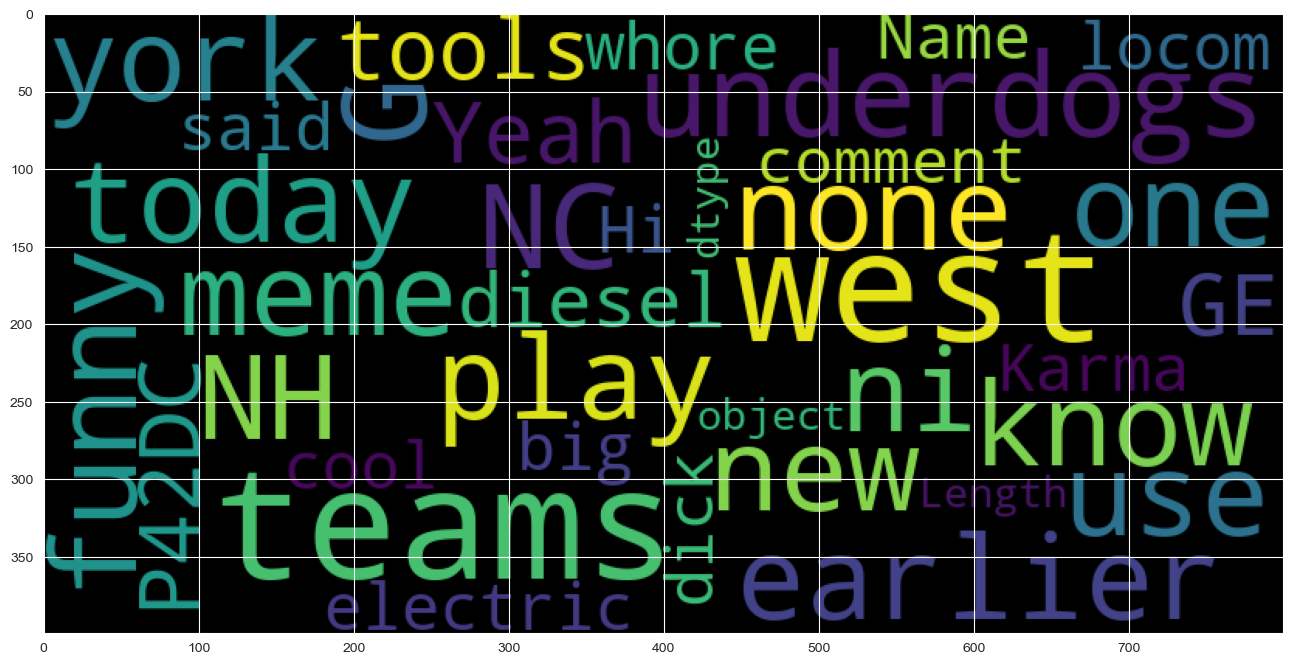

In [31]:
# 用词云的样式来统计数据中对应的comment的词语
from wordcloud import WordCloud, STOPWORDS
wordcloud = WordCloud(background_color= 'black', stopwords= STOPWORDS, max_words= 200, max_font_size= 100, random_state=17,
                       width = 800, height = 400)
plt.figure(figsize= (16, 12))
wordcloud.generate(str(train_df.loc[train_df['label'] == 0, 'comment',]))
plt.imshow(wordcloud)

In [33]:
## 使用groupby来确定哥哥板块讽刺评论数量排序
sub_df = train_df.groupby('subreddit')['label'].agg([np.size, np.mean, np.sum])
sub_df.sort_values(by= 'sum', ascending = False).head(10)

,size,mean,sum
subreddit,,,
AskReddit,65674,0.401453,26365
politics,39493,0.605348,23907
worldnews,26375,0.642540,16947
leagueoflegends,21034,0.542312,11407
pcmasterrace,18987,0.566651,10759
news,16891,0.603457,10193
funny,17939,0.451474,8099
pics,16152,0.484336,7823
todayilearned,14159,0.547567,7753


In [35]:
# 输出子板块评论数大于 1000, 且讽刺评论排名前10 的信息
sub_df[sub_df['size'] > 1000].sort_values(by = 'mean', ascending = False).head(10)

,size,mean,sum
subreddit,,,
creepyPMs,5466,0.784303,4287
MensRights,3355,0.680775,2284
ShitRedditSays,1284,0.661994,850
worldnews,26375,0.642540,16947
Libertarian,2562,0.640125,1640
atheism,7377,0.639555,4718
Conservative,1881,0.639553,1203
TwoXChromosomes,1560,0.632692,987
fatlogic,2356,0.623090,1468


In [36]:
# 输出发表总数大于三百, 且讽刺评论比例最好的10位用户信息
sub_df=train_df.groupby('author')['label'].agg([np.size, np.mean, np.sum])
sub_df[sub_df['size']> 300].sort_values(by='mean', ascending=False).head(10)

,size,mean,sum
author,,,
NeonDisease,422,0.500000,211
ShyBiDude89,404,0.500000,202
ivsciguy,342,0.500000,171
mindlessrabble,302,0.500000,151
mad-n-fla,318,0.500000,159
pokemon_fetish,432,0.500000,216
Biffingston,845,0.499408,422


In [57]:
# 训练分类模型
# 使用tf-id提取文本特征, 并建立逻辑回归模型
tf_idf = TfidfVectorizer(ngram_range=(1,2), max_features= 50000, min_df= 2)
#建立逻辑回归模型
logit = LogisticRegression(C = 1, n_jobs= 4, solver='lbfgs', random_state= 17, verbose=1)
# 使用sklearn pipline
tf_idf_logit_pipeline = Pipeline([('tf_idf', tf_idf), ('logit', logit)])

In [59]:
# 训练讽刺文本预测模型, 并得到测试集上准确评估结果
tf_idf_logit_pipeline.fit(train_texts, y_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Pipeline(steps=[('tf_idf',
                 TfidfVectorizer(max_features=50000, min_df=2,
                                 ngram_range=(1, 2))),
                ('logit',
                 LogisticRegression(C=1, n_jobs=4, random_state=17,
                                    verbose=1))])

In [50]:
valid_pred = tf_idf_logit_pipeline.predict(valid_texts)
accuracy_score(y_valid, valid_pred)

0.719992243552453

In [60]:
# 归一化处理
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(actual, predicted, classes, normalize = False,
                          title = 'Confusion matrix', figsize = (7,7),
                          cmap = plt.cm.Blues, path_to_save_fig = None):
    # 计算混淆矩阵
    cm = confusion_matrix(actual, predicted)
    # 归一化处理
    if normalize:
        cm = cm.astype('float')/cm.sum(axis = 1)[:,np.newaxis]
        fmt = '.2f' # 归一化的格式
    else:
        fmt = 'd' # 非归一化的格式

    # 创建图形
    plt.figure(figsize= figsize)
    plt.imshow(cm, interpolation= 'nearest', cmap = cmap)
    plt.colorbar()
    plt.title(title)

    #设置坐标轴
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation= 90)
    plt.yticks(tick_marks, classes)

    #设置阈值, 用于确定文本的颜色
    thresh = cm.max()/2.0 # 确定在使用前定义thresh

    #再混淆矩阵上标注数值
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i,j], fmt),
                 color= 'white' if cm[i,j] > thresh else 'black')

    # 设置标签
    plt.tight_layout()
    plt.xlabel('True label')
    plt.ylabel('Predicted label')

    #保存图形
    if path_to_save_fig:
        plt.savefig(path_to_save_fig)

    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\dongz\\Applications\\miniconda3\\Lib\\site-packages\\matplotlib\\pyplot.py'>

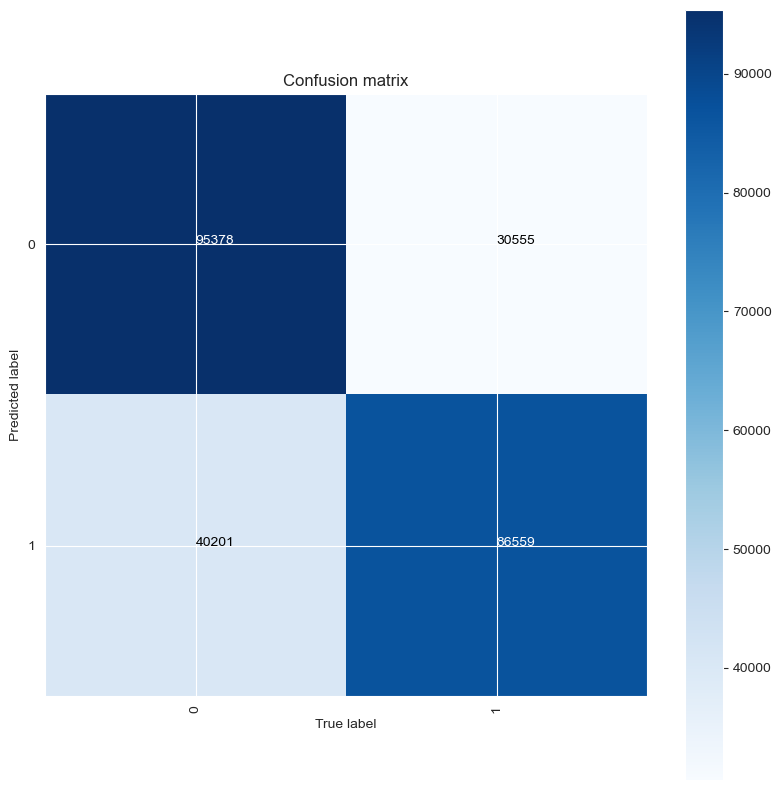

In [54]:
plot_confusion_matrix(y_valid, valid_pred, tf_idf_logit_pipeline.named_steps['logit'].classes_,
                      figsize=(8,8))

In [61]:
# 使用eli5 第三方库, 可以输出分类器的预测判定文本特征的权重
import eli5
eli5.show_weights(estimator= tf_idf_logit_pipeline.named_steps['logit'],
                  vec=tf_idf_logit_pipeline.named_steps['tf_idf'])

Weight?,Feature
+9.568,yes because
+7.956,clearly
+7.712,obviously
+7.176,totally
+7.003,yeah because
+6.523,because
+5.957,how dare
+5.871,right because
+5.549,duh
+5.292,but thought


In [63]:
# 从上面数据我们可以看出, 讽刺评论总通常用 yes because, obviously clearly 等带有肯定意味的词语

In [65]:
# 模型改进
# 我们期望得到进一步的改进, 所以我们在补充一个subreddit 特征, 同样完成切分(random_states确保能够与上面的评论数据对其)
subreddits = train_df['subreddit']
train_subreddits, valid_subreddits = train_test_split(subreddits, random_state=17)

In [66]:
# 接下来同样使用tf_idf算法分割构建两个TfidfVectorizer 用于comment 和subreddits的特征提取
tf_idf_texts = TfidfVectorizer(ngram_range=(1,2), max_features=50000, min_df=2)
tf_idf_subreddits = TfidfVectorizer(ngram_range=(1,1))
x_train_texts = tf_idf_texts.fit_transform(train_texts)
x_valid_texts = tf_idf_texts.transform(valid_texts)

x_train_texts.shape, x_valid_texts.shape

((758078, 50000), (252693, 50000))

In [68]:
x_trian_subreddits = tf_idf_texts.fit_transform(train_subreddits)
x_valid_subreddits = tf_idf_texts.transform(valid_subreddits)
x_trian_subreddits.shape, x_valid_subreddits.shape

((758078, 7799), (252693, 7799))

In [70]:
# 将提取的特征进行拼接
from scipy.sparse import hstack
x_train = hstack([x_train_texts, x_trian_subreddits])
x_valid = hstack([x_valid_texts, x_valid_subreddits])
x_train.shape, x_valid.shape

((758078, 57799), (252693, 57799))

In [71]:
logit.fit(x_train, y_train)
valid_pred = logit.predict(x_valid)
accuracy_score(y_valid, valid_pred)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


0.7228098918450452